In [235]:
import dwave
import dimod
import neal
import os
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridCQMSampler
from dimod import BinaryQuadraticModel, QuadraticModel, ConstrainedQuadraticModel, Binary, Integer, ExactCQMSolver, SimulatedAnnealingSampler
from neal import SimulatedAnnealingSampler
os.environ['DWAVE_API_TOKEN'] = 'DEV-02d687c5521a014df6c14e8a3ae5694cb67d5a8f'

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
import pandas as pd

from pulp import *

import sys
sys.path.append('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing')
from util.utils import get_index
from util.plots import plot_schedule
from uc_annealing import UC_Annealing

# Import data

In [236]:
demand = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Demand.csv')
fuel_data = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Fuels_data.csv')
generator = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Generators_data.csv')
variability = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Generators_variability.csv')

In [237]:
#we only want to keep the generators for which commitment is necessary
thermal_generators = generator[generator['Up_time']>0]

In [238]:
pd.set_option('display.max_columns', None)
thermal_generators = thermal_generators.drop_duplicates(subset=['Resource'], keep='first')
thermal_generators

,R_ID,Resource,region,Existing_Cap_MW,num_units,Cap_size,Var_OM_cost_per_MWh,Var_OM_cost_per_MWh_in,Fuel,Heat_rate_MMBTU_per_MWh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,Min_power,Ramp_Up_percentage,Ramp_Dn_percentage,Start_cost_per_MW,Start_fuel_MMBTU_per_MW,Up_time,Down_time,Self_disch,Eff_up,Eff_down,Ratio_power_to_energy,Min_Duration,Max_Duration,cluster,zone,voltage_level,CapRes,THERM,DISP,NDISP,STOR,DR,HEAT,NACC,TRADER,HYDRO,RPS,CES,Commit,Min_Share,Max_Share,Existing_Cap_MWh,unmodified_existing_cap_mw,New_Build,Min_Cap_MW,Max_Cap_MW,Min_Share_percent,Max_Share_percent,capex,Inv_cost_per_MWyr,Fixed_OM_cost_per_MWyr,capex_mwh,Inv_cost_per_MWhyr,Fixed_OM_cost_per_MWhyr,NACC_Eff,NACC_Peak_to_Base,Reg_Up,Reg_Dn,Rsv_Up,Rsv_Dn,Reg_Cost,Rsv_Cost,spur_miles,spur_capex,offshore_spur_miles,offshore_spur_capex,tx_miles,tx_capex,interconnect_annuity,Max_DSM_delay
2,3,natural_gas_fired_combined_cycle,WEC_SDGE,607.1,1,607.1,3.4,0,pacific_naturalgas,7.52,0.0,0.0,0.362,0.40,0.40,87,2.0,6,6,0,1.0,1.0,1.0,0,0,1,1,trans,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,607.1,1,0,0.0,0,0,0.000,0.0,9270,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0
8,9,natural_gas_fired_combustion_turbine,WEC_SDGE,91.6,2,45.8,10.8,0,pacific_naturalgas,10.69,0.0,0.0,0.800,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,1,1,trans,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,91.6,1,0,0.0,0,0,0.000,0.0,11182,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0
25,26,naturalgas_ccccsavgcf,WEC_SDGE,0.0,0,500.0,7.2,0,pacific_naturalgas_ccs90,7.52,0.0,0.0,0.600,0.64,0.64,95,3.5,6,6,0,1.0,1.0,1.0,0,0,0,1,trans,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1,0,-1.0,0,0,2215517.785,229065.0,33620,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0
26,27,naturalgas_ccavgcf,WEC_SDGE,0.0,0,500.0,2.0,0,pacific_naturalgas,6.28,0.0,0.0,0.200,0.64,0.64,95,3.5,6,6,0,1.0,1.0,1.0,0,0,0,1,trans,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1,0,-1.0,0,0,804772.856,114863.0,10032,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0
27,28,naturalgas_ctavgcf,WEC_SDGE,0.0,0,100.0,10.8,0,pacific_naturalgas,9.35,0.0,0.0,0.300,3.78,3.78,123,3.5,1,1,0,1.0,1.0,1.0,0,0,0,1,trans,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1,0,-1.0,0,0,699302.872,90151.0,6848,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0
29,30,naturalgas_ccs100,WEC_SDGE,0.0,0,500.0,7.7,0,pacific_naturalgas_ccs100,7.88,0.0,0.0,0.600,0.64,0.64,95,3.5,6,6,0,1.0,1.0,1.0,0,0,0,1,trans,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0.0,1,0,-1.0,0,0,2331517.785,241058.0,43290,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0


# Problem definition

This notebook gives a computational representation of the Constrained Quadratic Model (CQM) for the Unit Commitment (UC) problem for a plan operator that minimises the sum of total operating expenditure of generation across generation units and a demand shortfall penalty.

**Variables**
- N: number of power plants (n = 1, ..., N)
- T: time periods (t = 1, ..., T)
- i(n,t): composite index of size NT
- x_i: binary vector of size NT indicating the state of power plant (x_00 = 0 -> off, x_00 = 1 -> on)
- C_i: vector representing the cost of operating each power plant n at time t
- D(t): demand for a time period
- E_i: vector representing the efficiency of each power plant n at time t

# Constrained Quadratic Model

Constrained quadratic models describe optimization problems involving quadratic objectives and linear constraints. The goal is to find the values of the decision variables that minimize or maximize the objective function

$$\sum _i a_i x_i +\sum _{i \leq j} b_{ij} x_i x_j + c$$

while satisfying the given constraints

$$\sum _i a_i^{(m)} x_i +\sum _{i \leq j} b_{ij}^{(m)} x_i x_j + c^{(m)} \circ 0$$

where $M$ is the total number of constrainsts; $x_i$ can be a binary, integer or continuous variables, $a_i$, $b_{ij}$ and c are real values, and $\circ \in \{ \leq, \geq, = \}$.

In [239]:
# define a constrained quadratic model instance
cqm = ConstrainedQuadraticModel()

In [240]:
n_hours = 24
n_generators = thermal_generators.shape[0]
day_demand = demand['Demand'][:n_hours].values

#define the commitment variable
x = {(n, t): Binary('x_{}_{}'.format(n, t)) for n, rows in thermal_generators.iterrows() for t in range(n_hours)}

#define the generation variable 
y = {(n, t): Integer('y_{}_{}'.format(n, t)) for n, rows in thermal_generators.iterrows() for t in range(n_hours)}

In [241]:
#define the objective function
objective = QuadraticModel()
for generator, row in thermal_generators.iterrows():
    for hour in range(n_hours):
        heat_rate = thermal_generators['Heat_rate_MMBTU_per_MWh'][generator]
        fuel = thermal_generators['Fuel'][generator]
        fuel_cost = fuel_data[fuel_data['Fuel'] == fuel]['Cost_per_MMBtu'].values[0]
        VarOM = thermal_generators['Var_OM_cost_per_MWh'][generator]

        objective.update((heat_rate * fuel_cost + VarOM) * y[generator, hour])
        
cqm.set_objective(objective)

In [242]:
#define the energy demand contraint
for hour in range(n_hours):
    sum_energies = QuadraticModel()
    for generator, row in thermal_generators.iterrows():
        sum_energies += y[generator, hour]
    cqm.add_constraint(sum_energies >= day_demand[hour], label = f'energy demand hour {hour}')

In [243]:
cqm.constraints['energy demand hour 0'].to_polystring()

'y_2_0 + y_8_0 + y_25_0 + y_26_0 + y_27_0 + y_29_0 >= 2274.0'

In [244]:
#define the energy demand contraint
for hour in range(n_hours):
    for generator, row in thermal_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        min_power = row['Min_power']
        
        cqm.add_constraint(x[generator, hour] * existing_cap * min_power - y[generator, hour] <= 0,
                           label = f'energy lower bound generator {generator} at {hour}')
        
        cqm.add_constraint(x[generator, hour] * existing_cap - y[generator, hour] >= 0,
                           label = f'energy upper bound generator {generator} at {hour}')

In [245]:
#sample 
sampler = LeapHybridCQMSampler()
raw_sampleset = sampler.sample_cqm(cqm)
sample = raw_sampleset.first

In [247]:
feasible_sampleset = raw_sampleset.filter(lambda d: d.is_feasible)
num_feasible = len(feasible_sampleset)
if num_feasible > 0:
    best_samples = \
        feasible_sampleset.truncate(min(10, num_feasible))
else:
    best_samples = raw_sampleset.truncate(10)

print(" \n" + "=" * 30 + "BEST SAMPLE SET" + "=" * 30)
print(best_samples)

best_sample = best_samples.first.sample
# Separate x and y variables into two dictionaries
x_results = {}
y_results = {}

for key, value in best_sample.items():
    if key.startswith('x'):
        x_results[key] = value
    elif key.startswith('y'):
        y_results[key] = value

 
==============================BEST SAMPLE SET==============================
  x_25_0 x_25_1 x_25_10 x_25_11 x_25_12 ... y_8_9      energy num_oc. ...
0    1.0    0.0     1.0     0.0     0.0 ...   4.0 502632.2312       1 ...
1    1.0    0.0     0.0     0.0     0.0 ...  33.0 505924.4415       1 ...
2    1.0    0.0     0.0     0.0     0.0 ...   8.0 509929.7446       1 ...
3    1.0    1.0     0.0     1.0     1.0 ...  84.0 513670.1992       1 ...
4    1.0    0.0     0.0     1.0     1.0 ...  25.0 519061.1183       1 ...
5    0.0    1.0     0.0     1.0     1.0 ...  91.0 527310.8301       1 ...
6    0.0    1.0     1.0     0.0     1.0 ...   0.0 537916.6918       1 ...
7    1.0    1.0     1.0     0.0     0.0 ...   0.0 539026.6175       1 ...
8    0.0    0.0     1.0     0.0     1.0 ...  77.0 540136.5432       1 ...
9    0.0    0.0     1.0     1.0     1.0 ...  91.0 541060.3021       1 ...
['INTEGER', 10 rows, 10 samples, 288 variables]


In [248]:
# Prepare the data
generators = []
times = []
energies = []
resource = []
status = []

for key, value in y_results.items():
    key_parts = key.split('_')
    _, generator, time = key_parts
    generators.append(int(generator))
    times.append(int(time))
    energies.append(value)
    resource.append(thermal_generators['Resource'][int(generator)])

for key, value in x_results.items():
    status.append(value)

# Create a DataFrame
data_df = pd.DataFrame({
    'Generator': generators,
    'Resource' : resource,
    'Time': times,
    'Generated Energy': energies,
    'Status': status
})

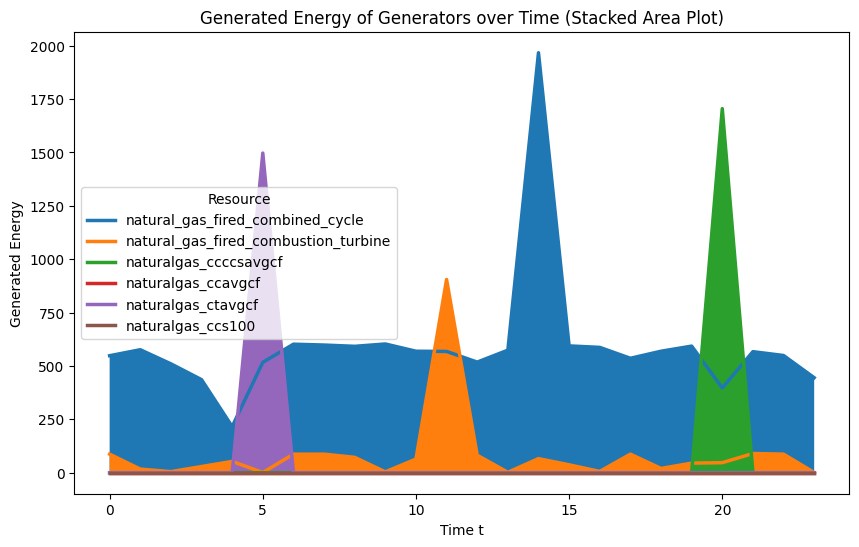

In [258]:
# Sort the DataFrame by the Generator and Time columns
data_df.sort_values(['Generator', 'Time'], inplace=True)

# Create the stacked area plot
plt.figure(figsize=(10, 6))
for generator, df_group in data_df.groupby('Generator'):
    sns.lineplot(x='Time', y='Generated Energy', data=df_group, linewidth=2.5, label=df_group.iloc[0]['Resource'])
    plt.fill_between(df_group['Time'], df_group['Generated Energy'], alpha=1)  # Fill area below the lines
plt.xlabel('Time t')
plt.ylabel('Generated Energy')
plt.title('Generated Energy of Generators over Time (Stacked Area Plot)')
plt.legend(title='Resource')
plt.show()

# Classical implementation

In [259]:
# Create a MILP problem
prob = LpProblem("Unit_Commitment_Problem", LpMinimize)

In [260]:
n_hours = 24
n_generators = thermal_generators.shape[0]
day_demand = demand['Demand'][:n_hours].values

# Decision variables
x = LpVariable.dicts("x", [(generator, t) for generator, rows in thermal_generators.iterrows() for t in range(n_hours)], cat="Binary")
y = LpVariable.dicts("y", [(generator, t) for generator, rows in thermal_generators.iterrows() for t in range(n_hours)], cat="Integer")

In [261]:
prob += lpSum([(thermal_generators['Heat_rate_MMBTU_per_MWh'][generator] * 
                fuel_data[fuel_data['Fuel'] == thermal_generators['Fuel'][generator]]['Cost_per_MMBtu'].values[0]
                + thermal_generators['Var_OM_cost_per_MWh'][generator]) * y[generator, t]
                for generator, row in thermal_generators.iterrows() for t in range(n_hours)])

In [262]:
#define the energy demand contraint
for hour in range(n_hours):
    prob += lpSum([y[generator, hour] for generator, row in thermal_generators.iterrows()]) >= day_demand[hour]

In [263]:
#define the energy demand contraint
for hour in range(n_hours):
    for generator, row in thermal_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        min_power = row['Min_power']

        prob += lpSum([x[generator, hour] * existing_cap * min_power - y[generator, hour]]) <= 0
        prob += lpSum([x[generator, hour] * existing_cap - y[generator, hour]]) >= 0

In [264]:
cqm.constraints['energy upper bound generator 8 at 4'].to_polystring()

'91.6*x_8_4 - y_8_4 >= 0.0'

In [265]:
# Solve the problem
prob.solve()

# Check the solution status
if LpStatus[prob.status] == 'Optimal':
    # Retrieve the optimal solution
    solution = {(n, t): value(x[n, t]) for n in range(n_generators) for t in range(n_hours)}
    total_cost = value(prob.objective)

else:
    print("No feasible solution found.")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/juanfrancisco/Desktop/uc/uc-problem-annealing/env/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/bdff45bbff114a26ab220ac4b03f638a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/bdff45bbff114a26ab220ac4b03f638a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 317 COLUMNS
At line 1374 RHS
At line 1687 BOUNDS
At line 1880 ENDATA
Problem MODEL has 312 rows, 192 columns and 528 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.04

No feasible solution found.


In [266]:
classical_solution = [(n, t) for (n, t), value in solution.items() if value == 1.0]

NameError: name 'solution' is not defined